# Federated Matrix Factorization

In this notebook we build a federated version of the well-known SVD recommender system introduced by [Simon Funk](https://sifter.org/~simon/journal/20061211.html) during the Netflix Prize. In the following we give a short description of the algorithm and point towards the relevant papers to develop a federated version.

The input data is a matrix $r_{iu}$, dubbed the item-user matrix, which contains the ratings that users (indexed by $u, v$) have given to different items (indexed by $i, j$). Since not all the users have rated every item, this matrix is typically large and very sparse (with missing values). The goal is to fill in the missing values given the information we have. This provides a dense matrix $\hat r_{iu}$ which contains an estimate of how users would rate items they have not yet interacted with. This information can then be used to give recommendations.

In this notebook, we will consider a simple case in which the guess for $\hat r_{iu}$ is given by
$$
\hat r_{iu} = \mu + q_i\cdot p_u
$$
where $\mu$ is the mean value of $r_{ui}$. For fixed item $i$ and user $u$, $q_i, p_u$ are vectors in $\mathbb R^f$, that have to be estimated based on the known $r_{iu}$. Here $f$ is an integer that defines the model.

In order to estimate $q_i, p_u$ we minimize the (L2-regularized) squared error function
$$
J(q, p) = \frac{1}{2}\sum_{(i,u)\in \mathcal K} e_{iu}^2 + \frac{1}{2}\sum_{i=1}^N \lambda^{(q)}_i ||q_i||^2 + \frac{1}{2}\sum_{u=1}^M  \lambda^{(p)}_u||p_u||^2 \,,
$$
with
$$
e_{iu} = r_{iu} - \mu - q_i\cdot p_u
$$
and where $\mathcal K$ is the set of tuples $(i,u)$ for which $r_{iu}$ is known and $ \lambda^{(q)}_i, \,\lambda^{(p)}_u$ are hyperparameters. Two popular approaches to estimate to optimize $J(q,p)$ are Alternating Least Squares (ALS) and Stochastic Gradient Descent (SGD).

In this notebook we implement both the standard SGD as well as a federated version. The latter is a mixture between the implementations described in [1711.07638](https://arxiv.org/abs/1711.07638) and in [1901.09888](https://arxiv.org/abs/1901.09888). In particular, we implemente an *explicit* SVD including Laplace noise in the gradients computed by each client. As it stands, the server knows which items the user has interacted with but does not know either the rating or the client's  latent factors. It would be interesting to include a Permanent Randomized Response (PRR) mechanism to hide the items the user has interacted with, as done in [1711.07638](https://arxiv.org/abs/1711.07638). (See also the notebook on the average attack.)

In the following we use the [MovieLens 100k dataset](https://grouplens.org/datasets/movielens/100k/) as an example.

In [1]:
import shfl
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

import os.path
import requests

path = "data/u.data"

if not os.path.isdir("data"):
    os.mkdir("data")
if not os.path.isfile(path):
    url = "http://files.grouplens.org/datasets/movielens/ml-100k/u.data"
    r = requests.get(url)
    open(path, "wb").write(r.content)
df = pd.read_csv(path, sep="\t", header=None, names=["userid", "itemid", "rating", "timestamp"]) \
        .drop("timestamp", axis=1)
# Both userid and itemid are integers from 0 to nUsers and nItems respectively
df["itemid"] = df["itemid"] - 1
df["userid"] = df["userid"] - 1

users = np.unique(df.userid.values)
items = np.unique(df.itemid.values)

df.head()

Using TensorFlow backend.


,userid,itemid,rating
0,195,241,3
1,185,301,3
2,21,376,1
3,243,50,2
4,165,345,1


We create the DataBase class that splits the data into train and test sets.

In [2]:
from shfl.data_base import data_base as db

class DataBaseSVD(db.DataBase):
    
    def load_data(self, df, p=0.8):
        """
        Splits the data intro train and test. The only non-null attributes of the class are train_data and test_data.
        All the attributes are arrays. The columns are: userid | itemid | rating
        
        # Arguments: 
            df: Dataframe of the form: userid | itemid | rating
                Both the userid and itemid are integers from 0 to the number of users and items
            p: float in [0,1]. Proportion of the data that goes into the training set
        """
        nObs = df.shape[0]
        data = df.sample(frac=1)
        train_data = df[:math.floor(nObs*p)]
        nTrain = train_data.shape[0]
        test_data = df[math.floor(nObs*p):]
        nTest = test_data.shape[0]
        self._train_data = np.array(train_data)
        self._train_labels = np.zeros(nTrain, dtype=np.int64)
        self._test_data = np.array(test_data)
        self._test_labels = np.zeros(nTest, dtype=np.int64)
        self._validation_data = np.array([], dtype=np.int64).reshape(0,3)
        self._validation_labels = np.array([], dtype=np.int64)

DB = DataBaseSVD()
DB.load_data(df, p=0.8)
DB.train[0]
# DB.test[0]

array([[ 195,  241,    3],
       [ 185,  301,    3],
       [  21,  376,    1],
       ...,
       [ 830,  357,    2],
       [ 460,  747,    1],
       [ 276, 1007,    3]])

In [3]:
from shfl.data_distribution import DataDistribution

class DataDistributionSVD(DataDistribution):
    """
    Implementation of the data distribution adapted to the case of SVD.
    """
    def make_data_federated(self, data, labels, num_nodes, percent, weights):
        """
        Method that makes data federated in an iid scenario.
        """

        # Shuffle data
        randomize = np.arange(data.shape[0])
        np.random.shuffle(randomize)
        data = data[randomize,]
        
        # Select percent
        nObs = data.shape[0]
        data = data[0:int(percent * nObs / 100), ]
        labels = labels[0:int(percent * nObs / 100)]
        
        num_nodes = len(np.unique(data[:,0]))

        federated_data = []
        federated_label = []
        for user in range(0, num_nodes):
            federated_data.append(data[data[:,0]==user])
            federated_label.append(labels[data[:,0]==user])
        
        federated_data = np.array(federated_data)
        federated_label = np.array(federated_label)

        return federated_data, federated_label


In [4]:
distData = DataDistributionSVD(DB)
num_nodes = len(users)
federated_data, test_data, test_label = distData.get_federated_data(num_nodes=num_nodes)

Check that the data is split correctly.

In [5]:
print("Number of nodes: " + str(federated_data.num_nodes()))

Number of nodes: 943


In [6]:
from shfl.private.query import IdentityFunction
from shfl.private.data import DataAccessDefinition

data_access_definition = DataAccessDefinition(query=IdentityFunction())
federated_data.configure_data_access(data_access_definition)
group_query = federated_data.query()
first_node = group_query[9]
print(first_node.data.shape)
print(first_node.label.shape)

print(first_node.data[0:5])
print(first_node.label[0:5])

(166, 3)
(166,)
[[  9 293   3]
 [  9   0   4]
 [  9 196   5]
 [  9 655   5]
 [  9 333   4]]
[0 0 0 0 0]


In [7]:
from shfl.model.model import TrainableModel

class ClientComputation(TrainableModel):
    """
    # Attributes:
        nItems: positive int. Total number of items
        f: positive int. Dimension of latent space.
        lam: positive float. Regularization parameter.
        g: positive float. SGD step.
        
        q_items: array of shape (nItems, f). Items' latent factors.

        userid: int
        nObs: number of ratings for a particular user
        mu: mean of the user's ratings
        p: An array of f elements. User's latent factors. 
        grad: A dictionary {itemid: array of length f} that contains the gradients for each item.
    """
    
    def __init__(self, nItems, f, lam, g, sensitivity, epsilon):
        self._nItems = nItems
        self._f = f
        self._lam = lam
        self._g = g
        self._sensitivity = sensitivity
        self._epsilon = epsilon
    
    def train(self, data_user, label_user):
        """
        Computes the user's  latent factors and the gradients.
        """
        nObs = len(data_user)
        mu = 3 # Rethink this 
        p = np.random.rand(self._f)
        grad = None
        
        q_items = self._q_items
        
        if nObs > 0:
            mu = np.mean(data_user[:,2])
            # LATENT FACTORS
            mat = self._lam * nObs * np.identity(self._f)
            vec = np.zeros(self._f)
            for obs in range(nObs):
                q = q_items[data_user[obs,1],:]
                mat += np.outer(q, q)
                vec += q * (data_user[obs, 2] - mu)
            p = np.matmul(np.linalg.inv(mat), vec)
            
            # GRADIENTS
            grad = dict.fromkeys(data_user[:,1]) # dictionary to save the gradients
            for obs in range(nObs):
                item = data_user[obs, 1]
                q = q_items[item,:]
                e = data_user[obs, 2] - mu - np.dot(q, p)
                grad[item] = self._g * (e * p - self._lam * q)
            
            # save all the attributes
            self._userid = data_user[0, 0]
            self._nObs = nObs
            self._mu = mu
            self._p = p
            self._grad = grad
        
    def predict(self, data_test):
        """
        The input data_test is of the form: userid | itemid | rating.
        """
        data_test = data_test[data_test[:,0]==self._userid]
        sum_square_error = 0
        nObs_test = data_test.shape[0]
        if nObs_test > 0:
            for obs in range(nObs_test):
                e = data_test[obs, 2] - self._mu - np.dot(self._q_items[data_test[obs, 1],:], self._p)
                sum_square_error += e * e
        return sum_square_error, nObs_test
        
    def get_model_params(self):
        return self._grad
    
    def set_model_params(self, q_items):
        self._q_items = q_items
        
    def evaluate(self):
        pass

In [8]:
from shfl.private.query import Query

class LaplaceDictionary(Query):
    """
    Implements the Laplace mechanism where the input is a dictionary and the noise is added to the values.
    
    # Arguments:
        sensitivity: float representing sensitivity of the applied query
        epsilon: float for the epsilon you want to apply
    
    """
    def __init__(self, sensitivity, epsilon):
        self._sensitivity = sensitivity
        self._epsilon = epsilon
    
    def get(self, data_dict):
        b = self._sensitivity/self._epsilon
        for key in data_dict.keys():
            data_dict[key] += np.random.laplace(loc=0.0, scale=b, size=len(data_dict[key]))
        return data_dict

We define a class that handles how to bring the gradients together to update the items' latent factors.

In [9]:
from shfl.federated_aggregator.federated_aggregator import FederatedAggregator

class GradientsAggregator(FederatedAggregator):
    """
    Implementation of the class that uses the gradients computed by each client
    to update the latent factor of the items.
    """
    def aggregate_weights(self, nItems, q_items, clients_params):
        nUsers = len(clients_params)
        
        for item in range(nItems):
            for user in range(nUsers):
                if item in clients_params[user].keys():
                    q_items[item,:] += clients_params[user][item]
                    
        return q_items

In [10]:
from shfl.learning_approach.learning_approach import LearningApproach
from shfl.differential_privacy.dp_mechanism import LaplaceMechanism

class FederatedSVD(LearningApproach):
    
    def train_all_clients(self):
        for data_node in self._federated_data:
            data_node.train_model()
    
    def get_global_rmse(self, data_test):
        rmse_mean = 0
        sum_square_error = 0
        nObs = 0
        for data_node in self._federated_data:
            sum_square_error += data_node.predict(data_test)[0]
            nObs += data_node.predict(data_test)[1]
        global_rmse = np.sqrt(sum_square_error/ nObs)
        return global_rmse

    def aggregate_weights(self, nItems, q_items):
        weights = []
        for data_node in self._federated_data:
            weights.append(data_node.query_model_params()) # the data in the nodes is accessed using a query
        aggregated_weights = self._aggregator.aggregate_weights(nItems, q_items, weights)
        self._model.set_model_params(aggregated_weights)
        for data_node in self._federated_data:  # At this point we update the q's of every node  
            data_node.set_model_params(aggregated_weights)

    def run_rounds(self, n, test_data, verbose=False):
        nItems = self._model._nItems
        f = self._model._f
        sensitivity = self._model._sensitivity
        epsilon = self._model._epsilon
        
        if sensitivity is not None and epsilon is not None:
            access = DataAccessDefinition(query=LaplaceDictionary(sensitivity=sensitivity, epsilon=epsilon))
        else:
            access = DataAccessDefinition(query=IdentityFunction())
        
        q_items = np.random.rand(nItems, f)  # random (but common) initialization
        for data_node in self._federated_data:
            data_node.configure_model_params_access(data_access_definition=access) # include DP if necessary
            data_node.set_model_params(q_items) # initialize
        if verbose: print("Global Test RMSE:")
        for i in range(n):
            self.train_all_clients()
            self.aggregate_weights(nItems, q_items)
            if verbose: print("\t Iteration " + str(i+1) + ": " + str(round(self.get_global_rmse(test_data), 3)))
        return self.get_global_rmse(test_data)

We start by computing the result without any differential privacy. In this case, the only difference with the non-federated model is that the value of $\mu$ is computed for each client independently.

In [11]:
def model_builder():
    model = ClientComputation(nItems=1682, f=10, lam=0.1, g=0.01, sensitivity=None, epsilon=None)
    return model

fedSVD = FederatedSVD(model_builder, federated_data, aggregator=GradientsAggregator())
result = fedSVD.run_rounds(15, test_data, verbose=True)

Global Test RMSE:
	 Iteration 1: 1.05
	 Iteration 2: 1.04
	 Iteration 3: 1.016
	 Iteration 4: 0.991
	 Iteration 5: 0.976
	 Iteration 6: 0.966
	 Iteration 7: 0.959
	 Iteration 8: 0.953
	 Iteration 9: 0.948
	 Iteration 10: 0.945
	 Iteration 11: 0.942
	 Iteration 12: 0.94
	 Iteration 13: 0.938
	 Iteration 14: 0.937
	 Iteration 15: 0.936


## Effect of differential privacy

In order to check the performance of the SVD when we add differential privacy, we start by computing the RMSE obtained using several different methods.

### Random ratings

We start by computing the RMSE that we get from filling the ratings matrix randomly with integers from 1 to 5.

In [12]:
test_ratings = DB.test[0][:,2]
RMSE_random = np.sqrt(np.sum(np.square(test_ratings - np.random.choice(range(1,5), len(test_ratings)))) / len(test_ratings))
print("RMSE using a random rating: " + str(round(RMSE_random,2)))

RMSE using a random rating: 1.88


### Mean rating

In [13]:
train_mean = np.mean(DB.train[0][:,2])
print("Mean rating: " + str(round(train_mean,2)))
test_ratings = DB.test[0][:,2]
RMSE_mean = np.sqrt(np.sum(np.square(test_ratings - train_mean)) / len(test_ratings))
print("RMSE using the mean rating: " + str(round(RMSE_mean,2)))

Mean rating: 3.53
RMSE using the mean rating: 1.12


### Non-Federated SVD

In this case, we include a non-federated SVD optimized using a simple Stochastic Gradient Descent.

In [14]:
%load_ext Cython

In [15]:
%%cython
cimport numpy as np
import numpy as np
import cython

def SVD_SGD(data_train, data_test, f, lam, g, nIter):
    
    cdef int nItems, nUsers, f_c, nIter_c, nObs_train, nObs_test
    cdef float lam_c, g_c, mu

    data_full = np.concatenate((data_train, data_test), axis=0)
    nUsers = len(np.unique(data_full[:,0]))
    nItems = len(np.unique(data_full[:,1]))
    
    data_train = np.array(data_train, dtype=long)
    data_test = np.array(data_test, dtype=long)
    
    cdef np.ndarray[np.long_t, ndim=2] data_train_c, data_test_c
    cdef np.ndarray[np.double_t, ndim=2] q_items, p_users
    
    f_c, lam_c, g_c, nIter_c = f, lam, g, nIter
    data_train_c = data_train
    data_test_c = data_test

    mu = np.mean(data_train[:,2])
    nObs_train = data_train.shape[0]
    q_items = np.random.rand(nItems, f_c)
    p_users = np.random.rand(f_c, nUsers)
    
    cdef double q, p, qp, e
    
    # TRAIN
    for i in range(nIter_c):
        for obs in range(nObs_train):
            qp = 0
            for k in range(f_c):
                qp += q_items[data_train_c[obs, 1],k] * p_users[k,data_train_c[obs, 0]]
            e = data_train_c[obs, 2] - mu - qp
            for k in range(f_c):
                q = q_items[data_train_c[obs, 1],k]
                p = p_users[k,data_train_c[obs, 0]]
                q_items[data_train_c[obs, 1],k] = q + g_c * (e * p - lam_c * q)
                p_users[k,data_train_c[obs, 0]] = p + g_c * (e * q - lam_c * p)
    
    # EVALUATE
    nObs_test = data_test.shape[0]
    RMSE = 0
    for obs in range(nObs_test):
        qp = 0
        for k in range(f_c):
            qp += q_items[data_test_c[obs, 1],k] * p_users[k,data_test_c[obs, 0]]
        e = data_test_c[obs, 2] - mu - qp
        RMSE += e * e
    RMSE = np.sqrt(RMSE / nObs_test)
    
    return RMSE

In [16]:
RMSE_nonF = SVD_SGD(data_train=DB.train[0], data_test=DB.test[0], f=10, lam=0.1, g=0.01, nIter=200)
print("RMSE for the non-federated SVD: " + str(round(RMSE_nonF, 2)))

RMSE for the non-federated SVD: 0.93


### Differentially private SVD

We train the model for different values of epsilon and check how the performance (in terms of the RMSE) decreases as the privacy increases. In this case we simply fix the sensitivity to $\Delta f = 0.01$.

In [17]:
n_iter = 15
epsilon_range = np.array([0.001, 0.01, 0.1, 0.2, 0.5, 1, 3])
RMSE = np.zeros(len(epsilon_range))

for i in range(len(epsilon_range)):
    def model_builder():
        model = ClientComputation(nItems=1682, f=10, lam=0.1, g=0.01, sensitivity=0.01, epsilon=epsilon_range[i])
        return model
    
    fedSVD = FederatedSVD(model_builder, federated_data, aggregator=GradientsAggregator())
    result = fedSVD.run_rounds(n_iter, test_data)
    RMSE[i] = result

We plot the RMSE as a function of $\epsilon$. The horizontal line corresponds to the RMSE obtained using the mean rating in the training set.

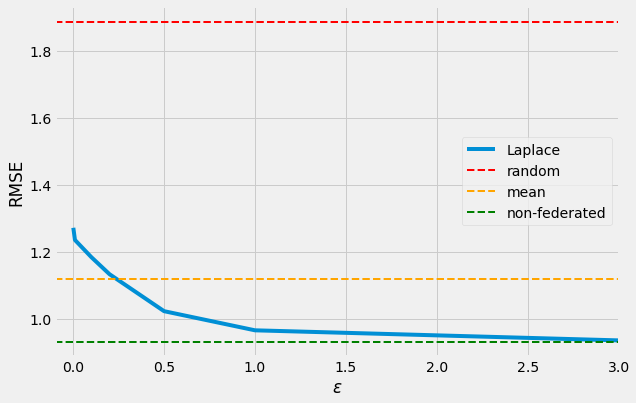

In [18]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(9,6))

plt.plot(epsilon_range, RMSE, label="Laplace")
plt.axhline(y=RMSE_random, color='r', linestyle='--', label="random", lw=2)
plt.axhline(y=RMSE_mean, color='orange', linestyle='--', label="mean", lw=2)
plt.axhline(y=RMSE_nonF, color='green', linestyle='--', label="non-federated", lw=2)
plt.xlabel('$\epsilon$')
plt.ylabel('RMSE')
ax.set_xlim([-0.1, max(epsilon_range)])
plt.legend(loc="center right")
plt.show()